In [1]:
import os, sys, time, copy
import random
import numpy as np
import matplotlib.pyplot as plt

import myokit
sys.path.append('../../../')
sys.path.append('../../../Protocols')
sys.path.append('../../../Models')
sys.path.append('../../../Lib')
import protocol_lib
import mod_trace

import simulator_myokit
import simulator_scipy

from agetdata import get_currents_with_constant_dt

C:\Anaconda3\envs\ml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [3]:
result_dir = "./Results"
try:
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    else:
        print("The folder already exsits")
except OSError:
    print(f"Error: {result_dir} has not been created.")

The folder already exsits


In [4]:
import vc_protocols
# VC_protocol = vc_protocols.hERG_CiPA()
# VC_protocol = vc_protocols.cav12_CiPA()
# VC_protocol = vc_protocols.lateNav15_CiPA()
VC_protocol = vc_protocols.leemV1_CiPA()

vhold = -80 # VC_protocol.steps[0].voltage

print(f'The protocol is {VC_protocol.get_voltage_change_endpoints()[-1]} ms')

The protocol is 1320 ms


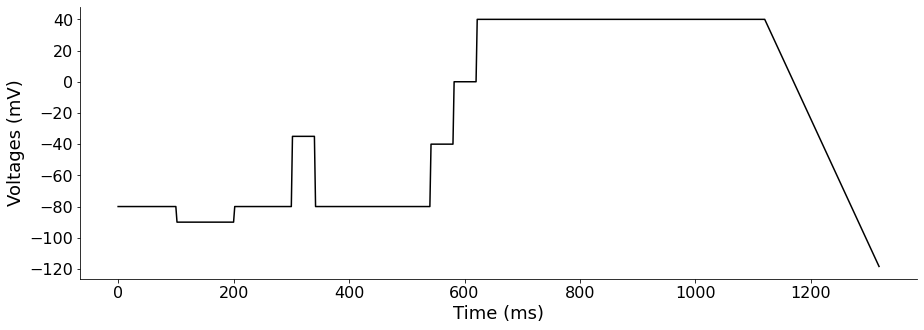

In [5]:
times = np.arange(0, VC_protocol.get_voltage_change_endpoints()[-1], 2) 
VC_protocol.plot_voltage_clamp_protocol(times)

In [6]:
cell_types = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}

cell_type = 'Endocardial'

ds_params = {
    'window' : 20,
    'step_size' : 10,   
    'window_type' : 'amax',
    'noise_sigma' : 0
}  

extra_log=['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL_total', 'ikr.IKr', 'iks.IKs', 'ik1.IK1', 'inaca.INaCa', 'inacass.INaCa_ss', 'inak.INaK', 'ikb.IKb', 'inab.INab', 'icab.ICab', 'ipca.IpCa']
end_time = VC_protocol.get_voltage_change_endpoints()[-1]
# t_eval = np.linspace(0, end_time, 10000)  

In [7]:
start_time = time.time()

model, p, s = myokit.load("../../../mmt-model-files/newordherg_qNet_vc_fixedconc-v1.mmt")    
sim = simulator_myokit.Simulator(model, VC_protocol, max_step=1.0, abs_tol=1e-06, rel_tol=1e-6, vhold=0)  # 1e-12, 1e-14  # 1e-08, 1e-10

model_params = {         
    'cell.mode': 0,
    'setting.simType': 1,   # 0: AP   |  1: VC      
}
sim.set_simulation_params(model_params)

print("--- %s seconds ---"%(time.time()-start_time))

--- 9.826582908630371 seconds ---


In [8]:
start_time = time.time()

model_params = {         
    'ina.GNafc' : 1,  
    'inal.GNaLfc' : 1,
    'ito.Gtofc' : 1,
    'ical.PCafc' : 1,
    'ikr.GKrfc' : 1,
    'iks.GKsfc' : 1,
    'ik1.GK1fc' : 1,    
}
sim.set_simulation_params(model_params)  

y0 = sim.pre_simulate(5000, sim_type=1)
d = sim.simulate(end_time, log_times=None, extra_log=['membrane.i_ion'] + extra_log)

sol1 = {}
times1 = d['engine.time']
sol1["Voltage"] = VC_protocol.get_voltage_clamp_protocol(d['engine.time'])
sol1["I_total"] = d['membrane.i_ion']
sol1["window_avg"] = get_currents_with_constant_dt(ds_params, [ d['engine.time'], d['membrane.i_ion'] ] )
sol1["window_amax"] = get_currents_with_constant_dt(ds_params, [ d['engine.time'], d['membrane.i_ion'] ] )
sol1["window_min"] = get_currents_with_constant_dt(ds_params, [ d['engine.time'], d['membrane.i_ion'] ] )
sol1["window_max"] = get_currents_with_constant_dt(ds_params, [ d['engine.time'], d['membrane.i_ion'] ] )
sol1["INa"] = d['ina.INa']
sol1["INaL"] = d['inal.INaL']
sol1["Ito"] = d['ito.Ito']
sol1["ICaL"] = d['ical.ICaL_total']
sol1["IKr"] = d['ikr.IKr']
sol1["IKs"] = d['iks.IKs']
sol1["IK1"] = d['ik1.IK1']

tr = mod_trace.Trace(VC_protocol,
                     cell_params=None,
                     t=times1,
                     y=sol1["Voltage"],  # simulator.model.V,
                     command_voltages=sol1["Voltage"],
                     current_response_info=sim.current_response_info,
                     default_unit=None)   
max_contributions1 = tr.current_response_info.get_max_current_contributions(time=times1, window=ds_params['window'], step_size=ds_params['step_size'])

print(len(sol1["window_min"]))

print("--- %s seconds ---"%(time.time()-start_time))

131
--- 0.29984211921691895 seconds ---


In [9]:
max_contributions1

,Current,Contribution,Time Start,Time End
0,i_ion,0.000000,0.0,20.0
1,INa,0.389624,540.0,560.0
2,INaL,0.283300,310.0,330.0
3,Ito,0.026215,630.0,650.0
4,ICaL_total,0.489435,590.0,610.0
5,IKr,0.374347,1200.0,1220.0
6,IKs,0.154609,1100.0,1120.0
7,IK1,0.490690,1300.0,1320.0
8,INaCa,0.025013,550.0,570.0
9,INaCa_ss,0.005983,550.0,570.0


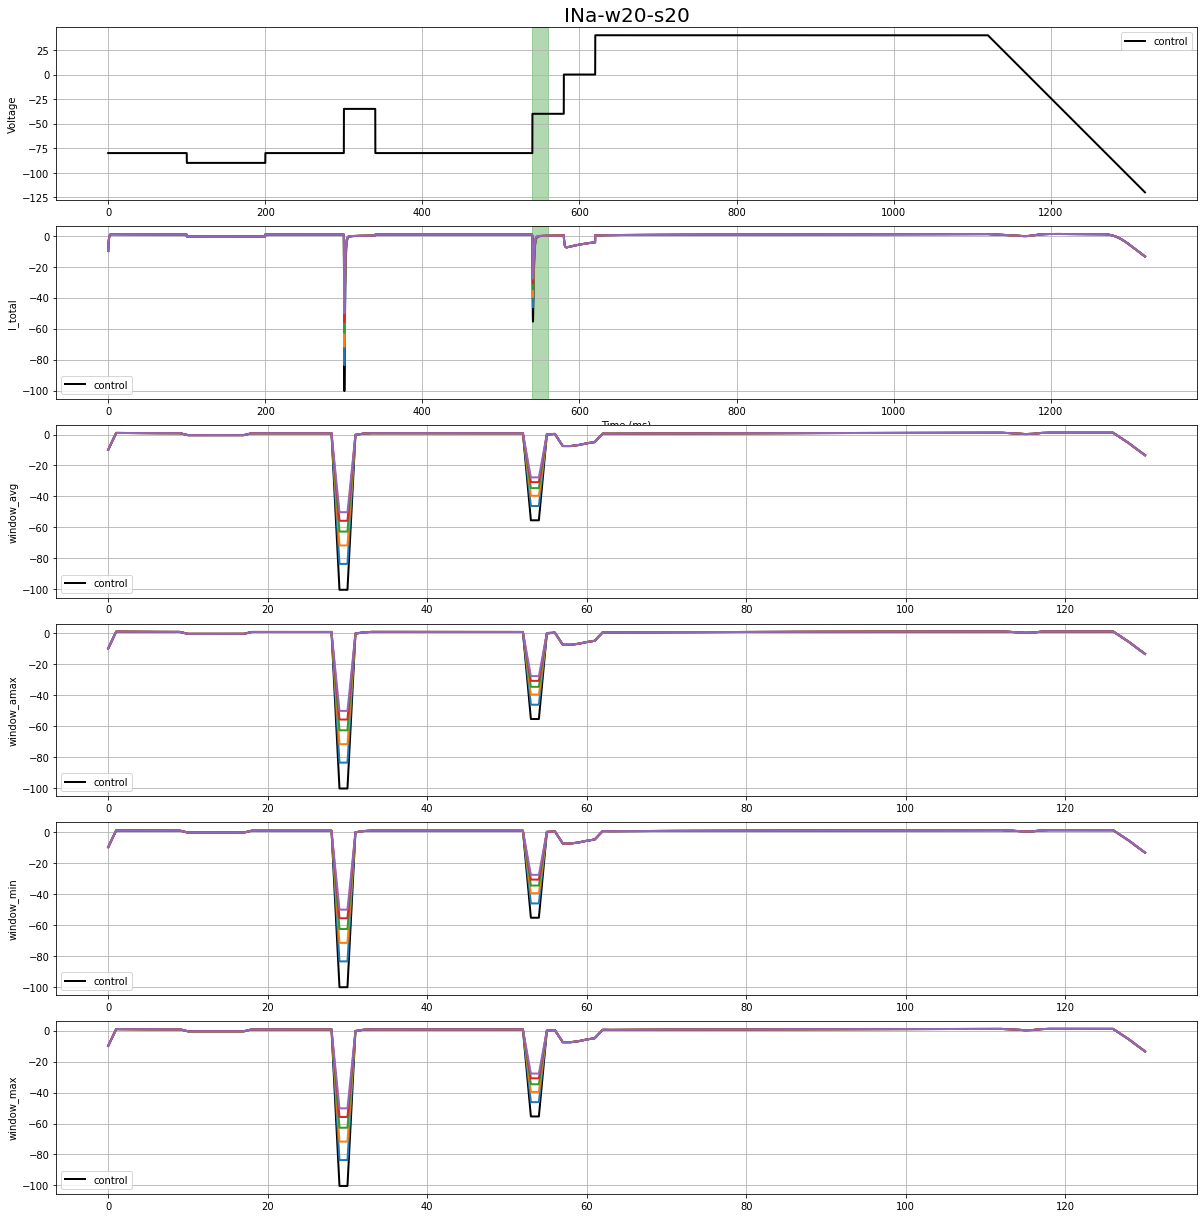

In [10]:
plot_li = ["I_total", "window_avg", "window_amax", "window_min", "window_max" ]
check_current = "INa"
nShow = 5
dy = 1.0/(nShow)


fig, ax = plt.subplots(6,1, figsize=(18,18))    
ax[0].set_title(f"{check_current}-w{ds_params['window']}-s{ds_params['window']}", fontsize=20)
for i, name in enumerate( ["Voltage"] + plot_li ):    
    ax[i].set_ylabel(f'{name}')  
    if name=='window_avg' or name=='window_amax' or name=='window_min' or name=='window_max':            
        ax[i].plot( sol1[name], label='control', color='k', linewidth=2)     
    else:
        ax[i].plot( times1, sol1[name], label='control', color='k', linewidth=2)         
    
        contribution = max_contributions1[max_contributions1["Current"]==check_current]['Contribution'].values[0]
        start = max_contributions1[max_contributions1["Current"]==check_current]['Time Start'].values[0]
        end = max_contributions1[max_contributions1["Current"]==check_current]['Time End'].values[0]         
        ax[i].axvspan(start, end, color='g', alpha=0.3)  
        
    ax[i].legend()
    ax[i].grid()


for j in range(1, nShow+1):
        
    # g_adj = random.random()
    # if i==0: g_adj = 1.0
        
    model_params = {         
        'ina.GNafc' : 1 + dy*j, 
        'inal.GNaLfc' : 1,
        'ito.Gtofc' : 1,
        'ical.PCafc' : 1,
        'ikr.GKrfc' : 1,
        'iks.GKsfc' : 1,
        'ik1.GK1fc' : 1,    
    }
    sim.set_simulation_params(model_params)  

    # sim.set_initial_values([-88] + y0)
    sim.pre_simulate(5000, sim_type=1)
    d = sim.simulate(end_time, log_times=None , extra_log=['membrane.VC', 'membrane.i_ion'] + extra_log)
    
    sol2 = {}
    times2 = d['engine.time']
    sol2["Voltage"] = d['membrane.VC']
    sol2["I_total"] = d['membrane.i_ion']
    sol2["window_avg"] = get_currents_with_constant_dt( ds_params, [ d['engine.time'], d['membrane.i_ion'] ] )
    sol2["window_amax"] = get_currents_with_constant_dt(ds_params, [ d['engine.time'], d['membrane.i_ion'] ] )
    sol2["window_min"] = get_currents_with_constant_dt( ds_params, [ d['engine.time'], d['membrane.i_ion'] ] )
    sol2["window_max"] = get_currents_with_constant_dt( ds_params, [ d['engine.time'], d['membrane.i_ion'] ] )    
    # sol2["INa"] = sim.current_response_info.get_current(['INa'])
    # sol2["INaL"] = sim.current_response_info.get_current(['INaL'])
    # sol2["Ito"] = sim.current_response_info.get_current(['Ito'])
    # sol2["ICaL"] = sim.current_response_info.get_current(['ICaL'])
    # sol2["IKr"] = sim.current_response_info.get_current(['IKr'])
    # sol2["IKs"] = sim.current_response_info.get_current(['IKs'])
    # sol2["IK1"] = sim.current_response_info.get_current(['IK1'])
    
    tr = mod_trace.Trace(VC_protocol,
                         cell_params=None,
                         t=times2,
                         y=sol2["Voltage"],  # simulator.model.V,
                         command_voltages=sol2["Voltage"],
                         current_response_info=sim.current_response_info,
                         default_unit=None)   
    max_contributions2 = tr.current_response_info.get_max_current_contributions(time=times2,
                                                                                window=ds_params['window'],
                                                                                step_size=ds_params['step_size'])
    
    
    '''
    Plot
    '''
    # current_name = 'IKr'
    
    # fig.suptitle(sim.name, fontsize=14)
    for i, name in enumerate(plot_li):            
        # ax.set_title('Simulation %d'%(simulationNo))
        # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())            
        # ax[i].plot( times1, sol1[name], label='control', color='k', linewidth=5)     
        if name=='window_avg' or name=='window_amax' or name=='window_min' or name=='window_max':            
            # ax[i].set_xlabel('Time (ms)')                   
            ax[i+1].plot( sol2[name], label='treatment', linewidth=2)    
        else:            
            ax[i+1].set_xlabel('Time (ms)')       
            ax[i+1].plot( times2, sol2[name], label='treatment', linewidth=2)    

        # if i!=0 and i!=1:
        #     contribution = max_contributions1[max_contributions1["Current"]==name]['Contribution'].values[0]
        #     start = max_contributions1[max_contributions1["Current"]==name]['Time Start'].values[0]
        #     end = max_contributions1[max_contributions1["Current"]==name]['Time End'].values[0]         
        #     ax[i].axvspan(start, end, color='g', alpha=0.3)  

    # ax[-1].set_ylim(-5, 5)

y_min = -50
y_max = 5
# ax[1].set_ylim(y_min, y_max)        
# ax[2].set_ylim(y_min, y_max)            

fig.savefig(os.path.join(result_dir, f"{check_current}_w{ds_params['window']}_s{ds_params['step_size']}.jpg"), dpi=100)
plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)
plt.show()